# Facies classification using Machine Learning

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a support vector machine to classify facies types.  Support vector machines (or SVMs) are a type of supervised learning model that can be trained on data to perform classification and regression tasks.  The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (or facies, in our case).  We will use the SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/svm.html).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

## Exploring the dataset


In [2]:
df = pd.read_csv("training_data.csv")
df

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

In [3]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Looking at the `count` values, there are 3232 feature vectors in the training set.

In [4]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Formation'] = label_encoder.fit_transform(df['Formation'])
df['Well Name'] = label_encoder.fit_transform(df['Well Name'])


In [5]:
df

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,1,7,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,1,7,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,1,7,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,1,7,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,1,7,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,12,0,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,12,0,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,12,0,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,12,0,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


## Data Cleaning

The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

Remove a single well to use as a blind test later.

In [6]:
blind = df[df['Well Name'] == 6]
training_data = df[df['Well Name'] != 6]

Out of the 8 Well types, Use 1 as blind data for testing and use the remaining 7 for training data

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

In [7]:
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,1,7,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,1,7,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,1,7,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,1,7,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,1,7,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,12,0,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,12,0,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,12,0,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,12,0,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


<Axes: title={'center': 'Distribution of Training Data by Facies'}>

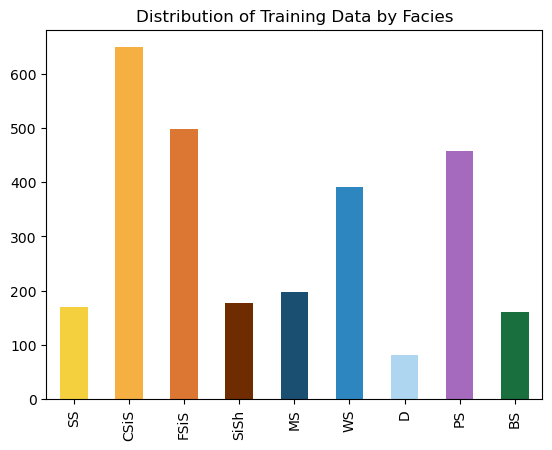

In [8]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')

In [9]:
facies_counts

SS      170
CSiS    649
FSiS    498
SiSh    177
MS      198
WS      391
D        81
PS      458
BS      161
Name: count, dtype: int64

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [10]:
correct_facies_labels = training_data['Facies'].values
correct_facies_labels

array([3, 3, 3, ..., 5, 5, 5])

In [11]:
feature_vectors = training_data.drop(['Facies'], axis=1)
feature_vectors

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,1,7,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,1,7,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,1,7,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,1,7,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,1,7,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...
3227,12,0,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,12,0,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,12,0,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,12,0,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


## Scaling Features

In [12]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [13]:
scaled_features

array([[-1.14811223,  1.80244524, -0.58165045, ...,  0.88852816,
        -1.04898873,  1.65923587],
       [-1.14811223,  1.80244524, -0.57803576, ...,  0.32921752,
        -1.04898873,  1.58617895],
       [-1.14811223,  1.80244524, -0.57442107, ..., -0.23009312,
        -1.04898873,  1.50964312],
       ...,
       [ 1.20019803, -1.28526455,  1.79319958, ..., -0.68872785,
         0.95329909,  0.50771957],
       [ 1.20019803, -1.28526455,  1.79681426, ..., -0.73123546,
         0.95329909,  0.47988836],
       [ 1.20019803, -1.28526455,  1.80042895, ..., -0.57127262,
         0.95329909,  0.45205715]])

## Splitting into training and test data"

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, correct_facies_labels, test_size=0.1, random_state=42)

## Training the Random Forest classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Evaluation for Random Forest classifier
rf_y_pred = rf.predict(X_test)
rf_report = classification_report(y_test, rf_y_pred)
rf_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

# Print evaluation metrics
print("Random Forest Classifier:")
print(rf_report)

Random Forest Classifier:
              precision    recall  f1-score   support

           1       0.95      0.79      0.86        24
           2       0.79      0.93      0.86        58
           3       0.86      0.78      0.82        40
           4       0.82      0.88      0.85        16
           5       0.89      0.53      0.67        30
           6       0.64      0.77      0.70        35
           7       1.00      0.91      0.95        11
           8       0.75      0.82      0.79        51
           9       1.00      0.86      0.92        14

    accuracy                           0.81       279
   macro avg       0.86      0.81      0.82       279
weighted avg       0.82      0.81      0.81       279



# We got an Accuracy of 0.81 with Random Forest Model

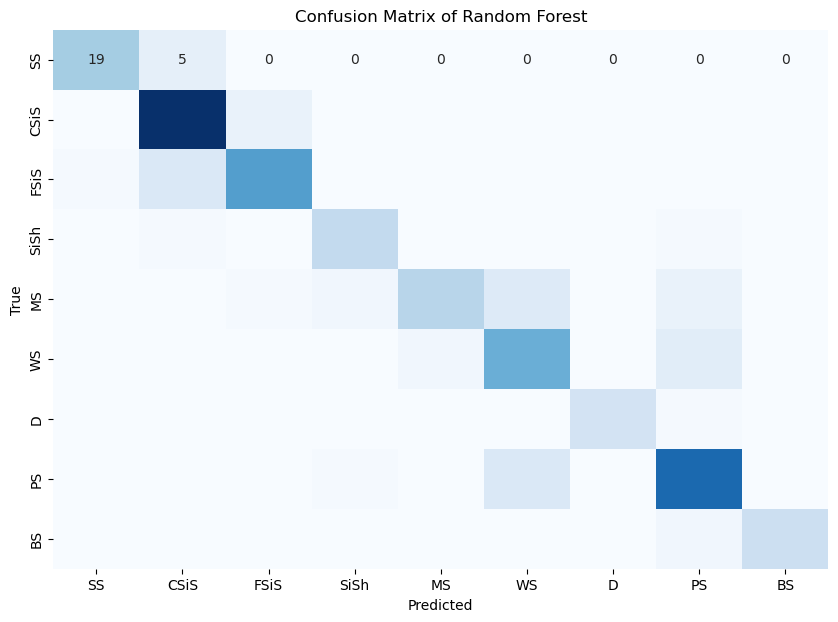

In [17]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d", 
            xticklabels=facies_labels, yticklabels=facies_labels,
            cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Random Forest')
plt.show()

## Training the SVM classifier

In [18]:
from sklearn import svm

# Build SVM model
svm_model = svm.SVC(random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [19]:
svm_predicted_labels = svm_model.predict(X_test)
svm_report = classification_report(y_test, svm_predicted_labels)
svm_conf_matrix = confusion_matrix(y_test, svm_predicted_labels)

# Print evaluation metrics
print("SVM Classifier:")
print(svm_report)

SVM Classifier:
              precision    recall  f1-score   support

           1       0.94      0.71      0.81        24
           2       0.68      0.78      0.73        58
           3       0.65      0.65      0.65        40
           4       0.63      0.75      0.69        16
           5       0.78      0.23      0.36        30
           6       0.49      0.74      0.59        35
           7       1.00      0.64      0.78        11
           8       0.72      0.76      0.74        51
           9       0.85      0.79      0.81        14

    accuracy                           0.68       279
   macro avg       0.75      0.67      0.68       279
weighted avg       0.71      0.68      0.67       279



# SVM model returns an Accuracy of 0.68

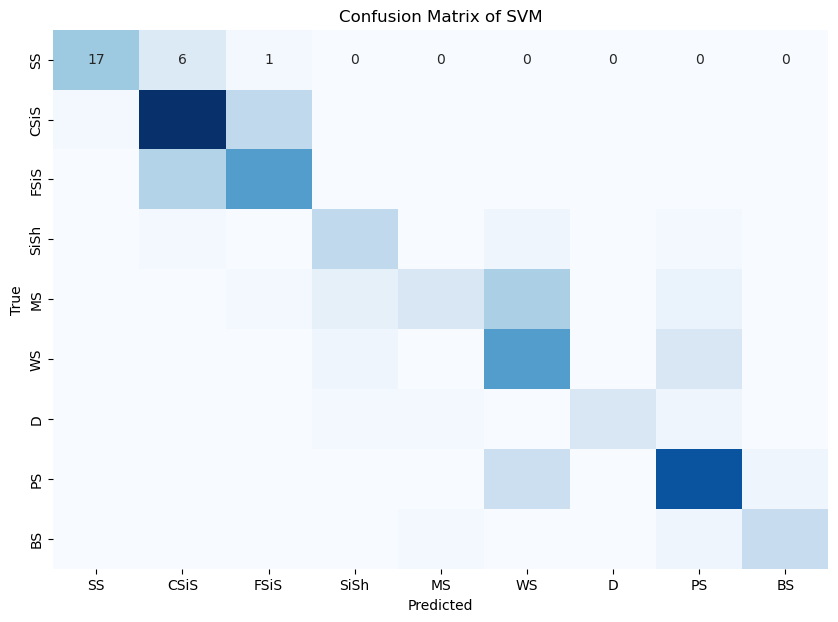

In [20]:
plt.figure(figsize=(10, 7))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", 
            xticklabels=facies_labels, yticklabels=facies_labels,
            cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of SVM')
plt.show()

In [21]:
## train an Adaboost Model

In [23]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize and train AdaBoost classifier
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [24]:
# Evaluation for Random Forest classifier
ab_y_pred = adaboost_model.predict(X_test)
ab_report = classification_report(y_test, ab_y_pred)
ab_confusion_matrix = confusion_matrix(y_test, ab_y_pred)

# Print evaluation metrics
print("Adaboost Classifier:")
print(ab_report)

Adaboost Classifier:
              precision    recall  f1-score   support

           1       0.49      0.83      0.62        24
           2       0.47      0.48      0.47        58
           3       0.45      0.25      0.32        40
           4       0.31      0.69      0.43        16
           5       0.00      0.00      0.00        30
           6       0.36      0.26      0.30        35
           7       0.19      0.27      0.22        11
           8       0.40      0.08      0.13        51
           9       0.21      1.00      0.35        14

    accuracy                           0.35       279
   macro avg       0.32      0.43      0.32       279
weighted avg       0.36      0.35      0.31       279



# Adaboost is giving the least accuracy of 0.35

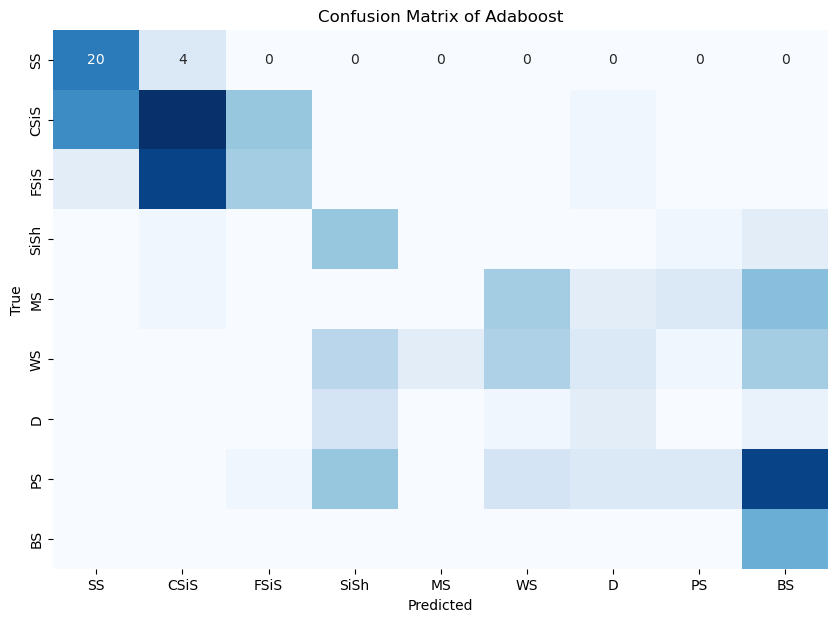

In [25]:
plt.figure(figsize=(10, 7))
sns.heatmap(ab_confusion_matrix, annot=True, fmt="d", 
            xticklabels=facies_labels, yticklabels=facies_labels,
            cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Adaboost')
plt.show()

In [26]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

## Model parameter selection

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

We will consider two parameters.  The parameter `C` is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples.  A large value of C will try to correctly classify more examples from the training set, but if `C` is too large  it may 'overfit' the data and fail to generalize when classifying new data. If `C` is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors.  Many kernel functions exist, but in this case we are using the radial basis function `rbf` kernel (the default).  The `gamma` parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

We will train a series of classifiers with different values for `C` and `gamma`.  Two nested loops are used to train a classifier for every possible combination of values in the ranges specified.  The classification accuracy is recorded for each combination of parameter values.  The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

This process is also known as 'cross validation'.  Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection.  For this tutorial we will just use the test set to choose model parameters.

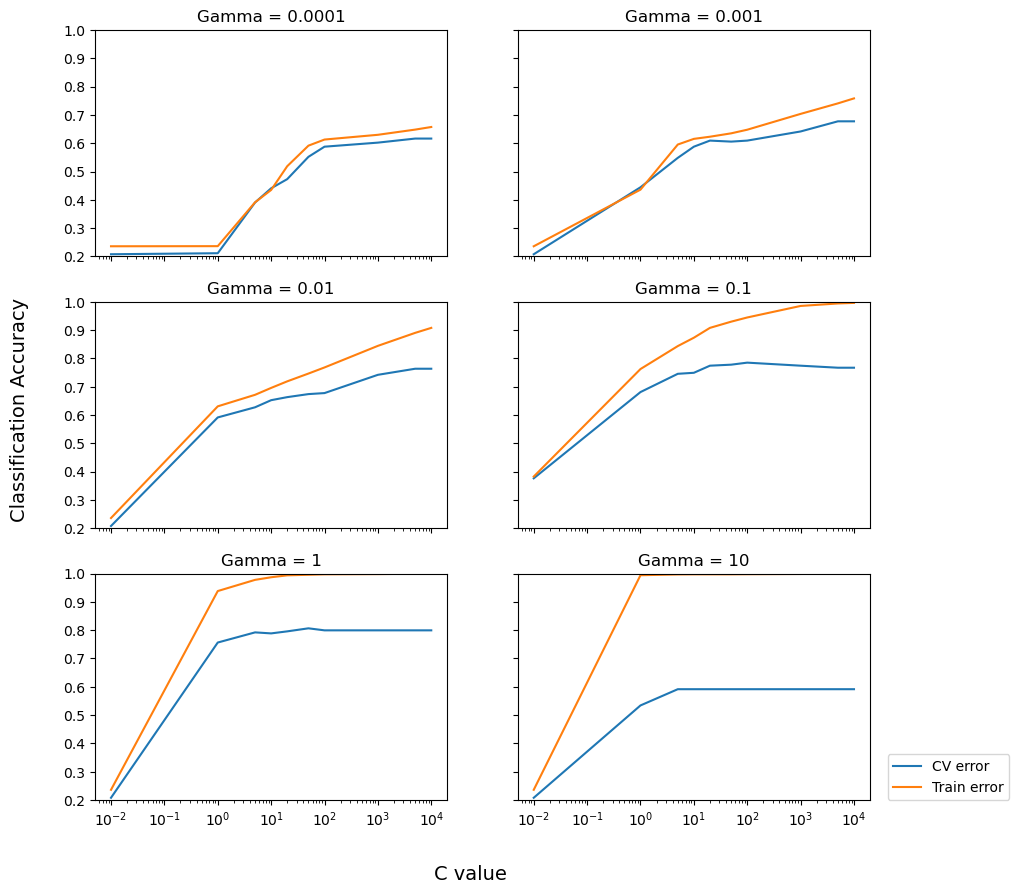

In [258]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

The best accuracy on the cross validation error curve was achieved for `gamma = 1`, and `C = 10`.  We can now create and train an optimized classifier based on these parameters:

In [27]:
clf = svm.SVC(C=10, gamma=1)        
clf.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [28]:
svm_predicted_labels = clf.predict(X_test)
svm_report = classification_report(y_test, svm_predicted_labels)
svm_conf_matrix = confusion_matrix(y_test, svm_predicted_labels)

# Print evaluation metrics
print("SVM Classifier with best parameters:")
print(svm_report)

SVM Classifier with best parameters:
              precision    recall  f1-score   support

           1       0.90      0.79      0.84        24
           2       0.79      0.91      0.85        58
           3       0.79      0.78      0.78        40
           4       0.67      0.75      0.71        16
           5       0.83      0.63      0.72        30
           6       0.70      0.74      0.72        35
           7       1.00      0.73      0.84        11
           8       0.75      0.78      0.77        51
           9       0.92      0.86      0.89        14

    accuracy                           0.79       279
   macro avg       0.82      0.78      0.79       279
weighted avg       0.80      0.79      0.79       279



# svm gives an accuracy of 0.79 with the tuned parameters

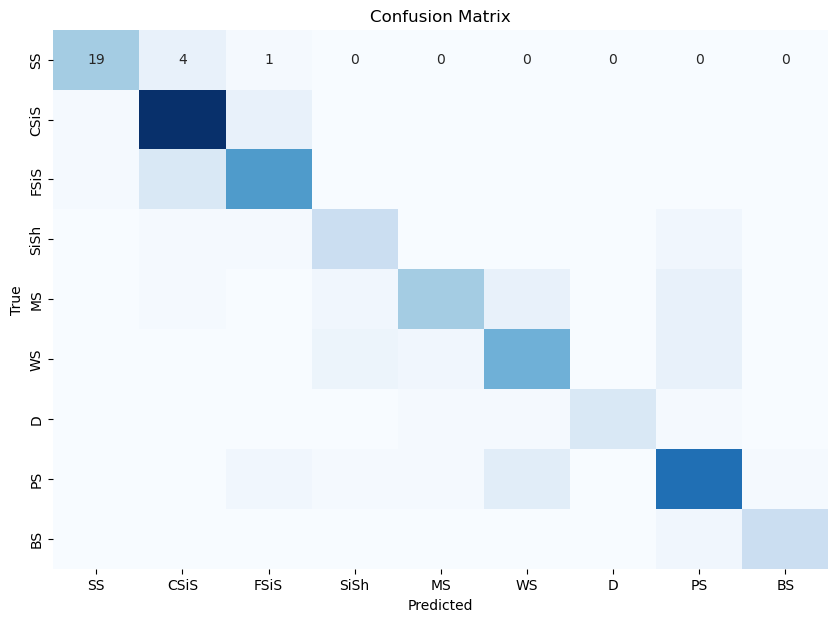

In [29]:
plt.figure(figsize=(10, 7))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", 
            xticklabels=facies_labels, yticklabels=facies_labels,
            cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [296]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],        # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required to be at a leaf node
}

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 661}
Best Score: 0.8118954091816366


In [30]:
# Use the best parameters found from grid search
best_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

# Initialize Random Forest classifier with best parameters
rf2_model = RandomForestClassifier(**best_params, random_state=42)

In [31]:
# Train the model on the entire training data
rf2_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Random Forest Classifier with best parameters:
              precision    recall  f1-score   support

           1       0.95      0.79      0.86        24
           2       0.79      0.93      0.86        58
           3       0.86      0.78      0.82        40
           4       0.82      0.88      0.85        16
           5       0.89      0.53      0.67        30
           6       0.64      0.77      0.70        35
           7       1.00      0.91      0.95        11
           8       0.75      0.82      0.79        51
           9       1.00      0.86      0.92        14

    accuracy                           0.81       279
   macro avg       0.86      0.81      0.82       279
weighted avg       0.82      0.81      0.81       279



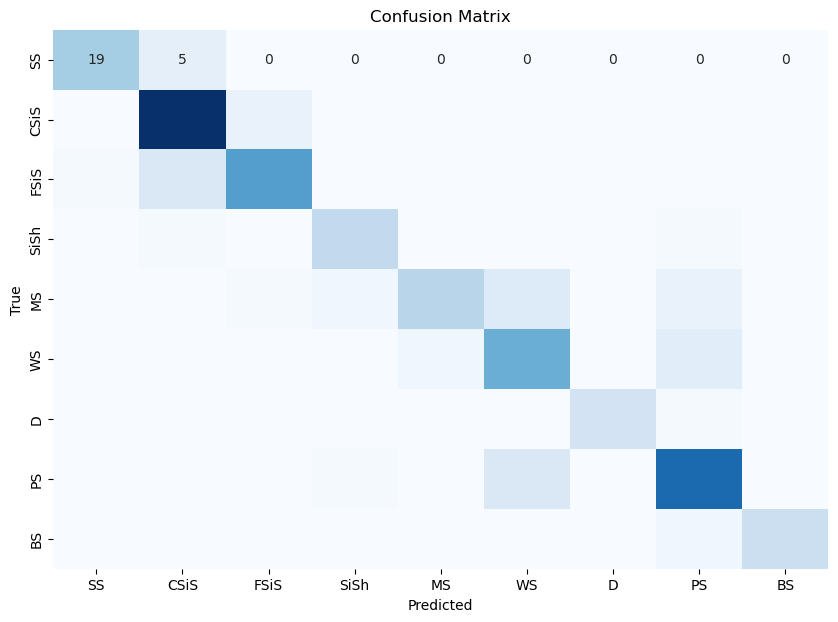

In [32]:
# Evaluation for Random Forest classifier
rf2_y_pred = rf2_model.predict(X_test)
rf2_report = classification_report(y_test, rf2_y_pred)
rf2_confusion_matrix = confusion_matrix(y_test, rf2_y_pred)

# Print evaluation metrics
print("Random Forest Classifier with best parameters:")
print(rf2_report)

plt.figure(figsize=(10, 7))
sns.heatmap(rf2_confusion_matrix, annot=True, fmt="d", 
            xticklabels=facies_labels, yticklabels=facies_labels,
            cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## So the SVM model gave 81% accuracy provided with the best hyperparameters. Next is the Random Forest with 77%

## Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [33]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,2,1,6,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
472,2,1,6,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
473,2,1,6,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
474,2,1,6,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
475,2,1,6,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...,...,...,...,...
915,8,12,6,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
916,8,12,6,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
917,8,12,6,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030
918,4,12,6,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030


The label vector is just the `Facies` column:

In [34]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [35]:
well_features = blind.drop(['Facies'], axis=1)
well_features

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,1,6,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
472,1,6,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
473,1,6,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
474,1,6,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
475,1,6,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...,...,...,...
915,12,6,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
916,12,6,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
917,12,6,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030
918,12,6,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030


In [36]:
X_blind = scaler.transform(well_features)

Now we can transform this with the scaler we made before:

In [37]:
from sklearn.preprocessing import StandardScaler

# Assuming you have new data in X_blind and the original scaler is scaler
scaler = StandardScaler()
scaler.fit(X_train)  # Fit with original training data
X_blind_scaled = scaler.transform(X_blind)  # Transform new data

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [38]:
y_pred = rf2_model.predict(X_blind)
blind['Prediction'] = y_pred

/var/folders/q8/nk0ky3s169j9lpcv9c73hkw40000gn/T/ipykernel_74220/2269752591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blind['Prediction'] = y_pred


In [39]:
y_pred

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 8, 8, 8,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 8, 8,
       8, 8, 8, 6, 6, 6, 8, 8, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 8, 8, 8, 8, 8, 8,
       6, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3,

Let's see how we did with the confusion matrix:

In [40]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))

Optimized facies classification accuracy = 0.50


## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [41]:
well_data = pd.read_csv('nofacies_data.csv')
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


In [42]:
well_data['Formation'] = label_encoder.fit_transform(well_data['Formation'])
well_data['Well Name'] = label_encoder.fit_transform(well_data['Well Name'])

The data needs to be scaled using the same constants we used for the training data.

In [43]:
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,1,1,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,1,1,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,1,1,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,1,1,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,1,1,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,13,0,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,13,0,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,13,0,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,13,0,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


In [44]:
X_unknown = scaler.transform(well_data)

/Users/sharath/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [45]:
#predict facies of unclassified data
y_unknown = rf2_model.predict(well_data)
well_data['Facies'] = y_unknown
well_data

/Users/sharath/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,1,1,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,4
1,1,1,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,4
2,1,1,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,4
3,1,1,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,4
4,1,1,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,4
...,...,...,...,...,...,...,...,...,...,...,...
825,13,0,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,9
826,13,0,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,9
827,13,0,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,9
828,13,0,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,9


In [46]:
y_unknown

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 4, 4, 4, 4,
       4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9,
       7, 7, 7, 8, 8, 8, 8, 7, 7, 7, 7, 9, 9, 9, 9, 9, 7, 9, 7, 9, 9, 7,
       7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9,
       9, 9, 9, 9, 9, 4, 4, 4, 7, 7, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 9, 9, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4,
       9, 9, 9, 9, 9, 9, 4, 4, 4, 9, 9, 9, 9, 9, 9, 4, 4, 4, 9, 9, 4, 4,
       4, 9, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 4, 4, 4, 4, 9, 9, 4, 4, 4,
       4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 8, 8, 8, 9, 9, 9, 9,
       9, 9, 4, 4, 9, 9, 9, 9, 9, 4, 4, 9, 9, 9, 9,

We can use the well log plot to view the classification results along with the well logs.

Finally we can write out a csv file with the well data along with the facies classification results.

In [47]:
well_data.to_csv('well_data_with_facies.csv')

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)